# Style Transfer 
#### 출처 : https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Style_Transfer_Tutorial.ipynb
#### 논문 링크 : https://rn-unison.github.io/articulos/style_transfer.pdf

#### style feat을 어떻게 표현할까? 라는 고민을 gram matrix를 사용하였다.

#### gram matrix는 각 feature들의 공분산을 활용하여 구한다




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

import PIL
import matplotlib.pyplot as plt

import copy


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [ ]:
!git clone https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice
%cd Deep-Learning-Paper-Review-and-Practice

Cloning into 'Deep-Learning-Paper-Review-and-Practice'...
remote: Enumerating objects: 462, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 462 (delta 72), reused 190 (delta 65), pack-reused 261
Receiving objects: 100% (462/462), 53.82 MiB | 21.91 MiB/s, done.
Resolving deltas: 100% (152/152), done.
/content/Deep-Learning-Paper-Review-and-Practice


## 이미지 로드 함수

In [ ]:
def image_loader(path, size):
  trans = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor()
  ])
  image = PIL.Image.open(path)
  image = trans(image).unsqueeze(0)
  return image.to(device)

def imshow(img): 
  image = img.cpu().clone() #matplotlib 은 cpu 기반이므로 cpu로 변경
  image = image.squeeze(0)

  image = transforms.ToPILImage()(image) #텐서객체에서 PIL객체로 변경
  plt.imshow(image)
  plt.show()


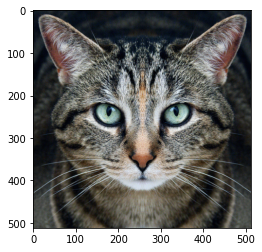

torch.Size([1, 3, 512, 512])


In [ ]:
img_path = './code_practices/images/cat.jpg'
target_image = image_loader(img_path, (512, 512))
imshow(target_image)
print(target_image.shape)

In [ ]:
print(torch.rand(3,3))
print(torch.empty(3,3).uniform_(0, 1))

tensor([[0.9384, 0.5921, 0.4680],
        [0.3178, 0.9280, 0.4471],
        [0.4574, 0.2662, 0.5698]])
tensor([[0.8807, 0.8065, 0.9537],
        [0.7220, 0.7402, 0.8332],
        [0.6843, 0.6560, 0.5930]])



## 노이즈에서 MSE Loss를 활용하여 훈련시키면 이미지를 찾아갈 수 있다.

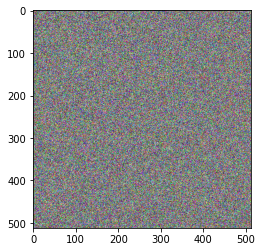

torch.Size([3, 512, 512])


In [ ]:
noise = torch.rand((3, 512, 512)).to(device)
imshow(noise)
print(noise.shape)

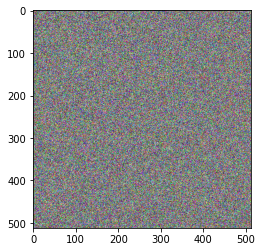

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 3, 512, 512])) that is different to the input size (torch.Size([3, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Step : 10 Loss :  tensor(0.1041, device='cuda:0', grad_fn=<MseLossBackward0>)


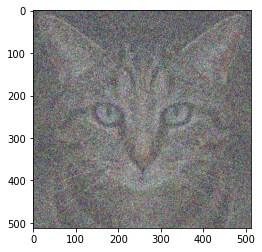

Step : 20 Loss :  tensor(0.0622, device='cuda:0', grad_fn=<MseLossBackward0>)


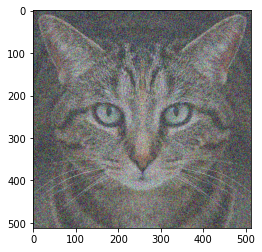

Step : 30 Loss :  tensor(0.0371, device='cuda:0', grad_fn=<MseLossBackward0>)


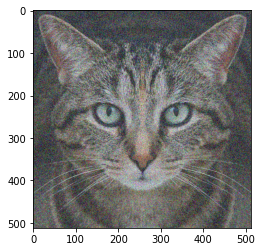

Step : 40 Loss :  tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)


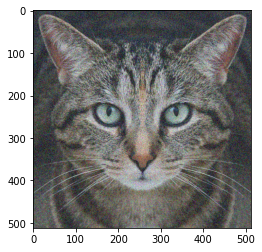

Step : 50 Loss :  tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)


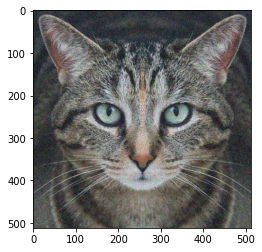

Step : 60 Loss :  tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)


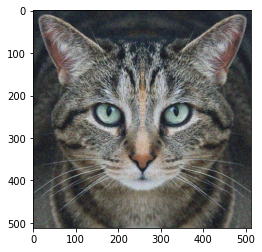

Step : 70 Loss :  tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)


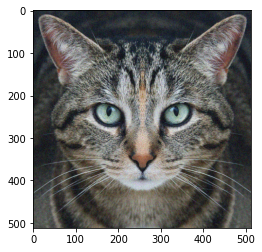

Step : 80 Loss :  tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward0>)


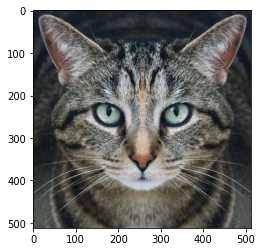

Step : 90 Loss :  tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


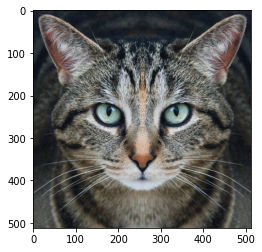

Step : 100 Loss :  tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


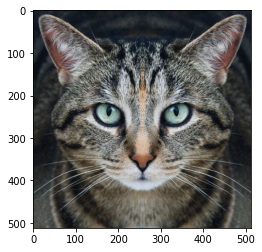

In [ ]:
loss = nn.MSELoss()
iters = 100
lr = 1e4

imshow(noise)

for i in range(iters):
  noise.requires_grad = True

  output = loss(noise, target_image)
  output.backward()

  gradient = lr * noise.grad
  noise = torch.clamp(noise - gradient, min = 0, max = 1).detach()

  if (i + 1) % 10 == 0:
    print('Step :', i+1, 'Loss : ', output)
    imshow(noise)

  

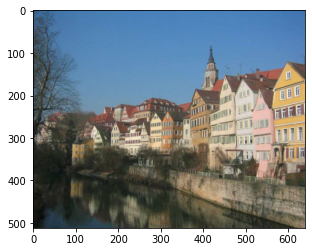

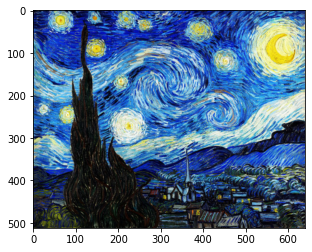

In [ ]:
content_img = image_loader('./code_practices/images/content_img_1.jpg', (512, 640))
style_img = image_loader('./code_practices/images/style_img_1.jpg', (512, 640))

imshow(content_img)
imshow(style_img)

# 모델 준비(vgg16)

In [ ]:
cnn = torchvision.models.vgg16(pretrained = True).features.to(device).eval()
print(cnn)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
device

device(type='cuda')

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = mean.clone().view(-1, 1, 1)
    self.std = std.clone().view(-1, 1, 1)

  def forward(self, img):
    return (img - self.mean) / self.std

# gram matrix 정의

## 각각의 feature를 transpose해서 곱해주어 공분산을 구해준다.

## 이러한 공분산을 style image와 비교하여 mse loss를 적용해준다.

In [ ]:
def gram_matrix(input):
  a, b, c, d = input.size()

  features = input.view(a * b, c * d)

  G = torch.mm(features, features.t())

  return G.div(a * b * c * d)

class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input) 
    self.loss = F.mse_loss(G, self.target) #
    return input

In [ ]:
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# 스타일 손실(style loss)을 계산하는 함수
def get_style_losses(cnn, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach() #layer를 거친 style_img
            style_loss = StyleLoss(target_feature)  #Style gram matrix를 품고 있는 Styleloss객체 생성
            model.add_module("style_loss_{}".format(i), style_loss) #model 에다 추가
            style_losses.append(style_loss)

    # 마지막 style loss 이후의 레이어는 사용하지 않도록 설정
    for i in range(len(model) - 1, -1, -1): #모델 아래서부터 style layer 있는지 확인
        if isinstance(model[i], StyleLoss): #있다면 for문 멈추고 i값 기억
            break

    model = model[:(i + 1)] #i값(마지막 style layer)까지 model구성
    return model, style_losses #모델 return

In [ ]:
## Style loss 가 model에 어떻게 들어가있는지 확인
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
model1 = nn.Sequential()
input_img1 = torch.rand(1, 3, 512, 640).to(device)
style_losses = []
i = 0
for layer in cnn.children():
  if isinstance(layer, nn.Conv2d):
    i += 1
    name = 'conv_{}'.format(i)
  elif isinstance(layer, nn.ReLU):
    name = 'relu_{}'.format(i)
    layer = nn.ReLU(inplace=False)
  elif isinstance(layer, nn.MaxPool2d):
    name = 'pool_{}'.format(i)
  elif isinstance(layer, nn.BatchNorm2d):
    name = 'bn_{}'.format(i)
  model1.add_module(name, layer)
  if name in style_layers:
    target_feature = model1(input_img1).detach()
    print(target_feature.shape)
    style_loss = StyleLoss(target_feature)
    style_losses.append(style_loss)
    print(style_losses) #StyleLoss의 객체 5개 가지고 있는 걸 확인
    model1.add_module('style_loss{}'.format(i), StyleLoss(target_feature))

torch.Size([1, 64, 512, 640])
[StyleLoss()]
torch.Size([1, 64, 512, 640])
[StyleLoss(), StyleLoss()]
torch.Size([1, 128, 256, 320])
[StyleLoss(), StyleLoss(), StyleLoss()]
torch.Size([1, 128, 256, 320])
[StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss()]
torch.Size([1, 256, 128, 160])
[StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss()]


In [ ]:
model1 #실제 모델 구성요소. style layer는 5개까지만 있다.
# 각각의 이미지들이 Style loss 를 거치면서 output값을 내보낸다.
#(여기서 output은 StyleLoss클래스의 forward 연산 수행되어서 나온 결과)

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss5): StyleLoss()
  (relu_5): ReLU()
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_6): ReLU()
  (conv_7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
for i in range(len(model1) - 1, -1, -1):
  if isinstance(model1[i], StyleLoss):
    break
print('i : ', i)
model1 = model1[:(i + 1)]
model1 #마지막 style loss까지 남긴 것을 확인

i :  15


Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss5): StyleLoss()
)

In [ ]:
def style_reconstruction(cnn, style_img, input_img, iters):
    model, style_losses = get_style_losses(cnn, style_img, input_img) #기본 모델, StyleLoss객체 return
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure(): #이 closure부분은 왜 사용했는지 모르겠다.
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img) #input이미지 넣어주고 style_losses 에 있는 StyleLoss객체들은 업데이트 된다.
            style_score = 0

            for sl in style_losses: 
                style_score += sl.loss #각각의 StyleLoss 객체에서 input값 받은 loss 반환

            style_score *= 1e6
            style_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"[ Step: {run[0]} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

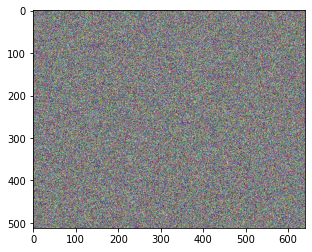

In [ ]:
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

[ Start ]


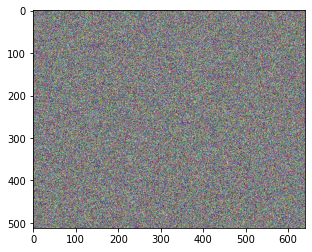

[ Step: 50 / Style loss: 500.9019470214844]


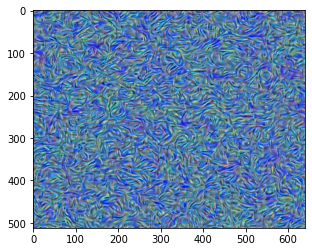

[ Step: 100 / Style loss: 139.58303833007812]


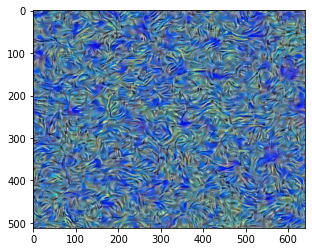

[ Step: 150 / Style loss: 67.47559356689453]


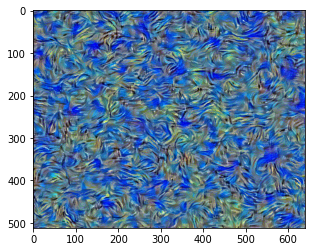

[ Step: 200 / Style loss: 44.865211486816406]


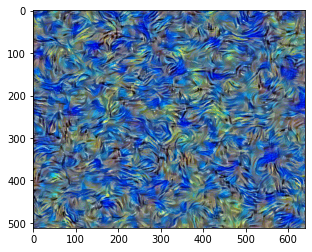

[ Step: 250 / Style loss: 33.64610290527344]


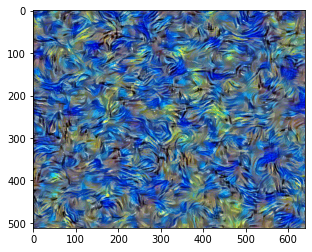

[ Step: 300 / Style loss: 25.70255470275879]


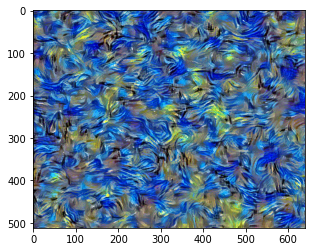

In [ ]:
output = style_reconstruction(cnn, style_img = style_img, input_img = input_img, iters = 300 )

In [ ]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()

    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input


In [ ]:
content_layers = ['conv_4']

def get_content_losses(cnn, content_img, noise_img):
  cnn = copy.deepcopy(cnn)
  normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
  content_losses = []

  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace = False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    
    model.add_module(name, layer) #vgg16의 모든 레이어들을 모델에 추가한다.

    if name in content_layers: #4번째 conv layer까지 담은 이미지특징을 살린다.
      target_feature = model(content_img).detach()
      content_loss = ContentLoss(target_feature)
      model.add_module('content_loss_{}'.format(i), content_loss)
      content_losses.append(content_loss)

  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss):
      break
  model = model[:(i+1)]
  return model, content_losses

In [ ]:
def content_reconstruction(cnn, content_img, input_img, iters):
    model, content_losses = get_content_losses(cnn, content_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0

            for cl in content_losses:
                content_score += cl.loss

            content_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()}]")
                imshow(input_img)
            
            return content_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

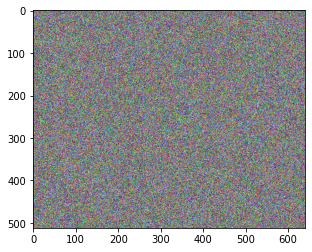

In [ ]:
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

[ Start ]


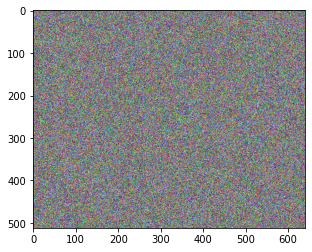

[ Step: 50 / Content loss: 1.0372594594955444]


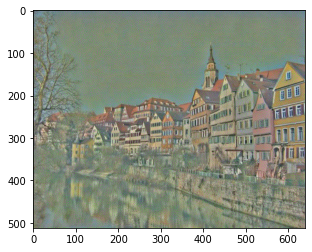

[ Step: 100 / Content loss: 0.5435006022453308]


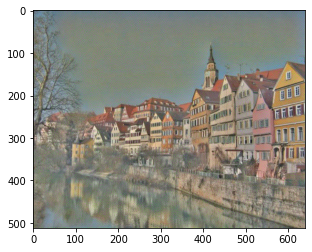

[ Step: 150 / Content loss: 0.3639371395111084]


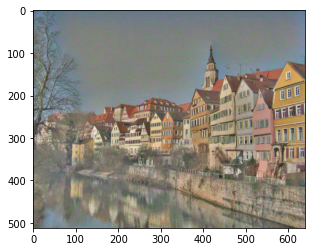

[ Step: 200 / Content loss: 0.2718644142150879]


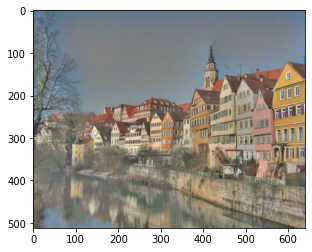

[ Step: 250 / Content loss: 0.2108539193868637]


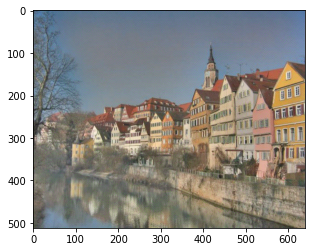

[ Step: 300 / Content loss: 0.1612018197774887]


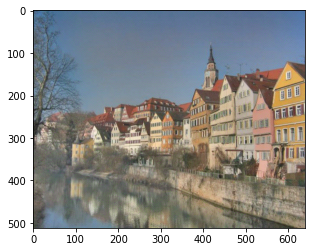

In [ ]:
output = content_reconstruction(cnn, content_img=content_img, input_img=input_img, iters=300)

In [ ]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_7', 'conv_9']

def get_losses(cnn, content_img, style_img, noise_img):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children(): # vgg의 모든 레이어 반복
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        #for문을 거치면서 모든 레이어에 설정한 이름, 번호 붙인다.
        model.add_module(name, layer)

        if name in content_layers: #conv 4번째 layer까지의 특징 추출
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature) #4번째 레이어까지의 특징 추출 이용하여 loss계산
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers: #1, 3, 5, 7, 9번째 conv layer까지의 style특징 추출
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses, style_losses

In [ ]:
def style_transfer(cnn, content_img, style_img, input_img, iters):
  model,  content_losses, style_losses = get_losses(cnn, content_img, style_img, input_img)
  optimizer = optim.LBFGS([input_img.requires_grad_()]) #모델은 고정되있으므로 이미지 업데이트

  imshow(input_img)

  run = [0]
  while run[0] <= iters:
    def closure():
      input_img.data.clamp_(0, 1)

      optimizer.zero_grad()

      model(input_img)
      content_score = 0
      style_score = 0

      for cl in content_losses:
        content_score += cl.loss
      for sl in style_losses:
        style_score += sl.loss

      style_score *= 1e5
      loss = content_score + style_score
      loss.backward()

      run[0] += 1
      if run[0] % 100 == 0:
        print(f'Step : {run[0]}, Content Loss : {content_score}, Style Loss : {style_score}')

        imshow(input_img)

      return content_score + style_score

    optimizer.step(closure)
  input_img.data.clamp_(0, 1)
  return  input_img

[ Content Image ]


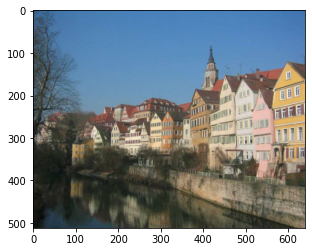

[ Style Image ]


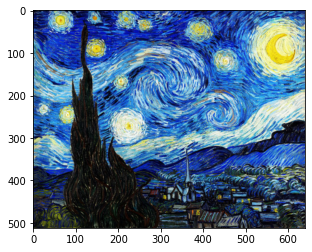

[ Input Image ]


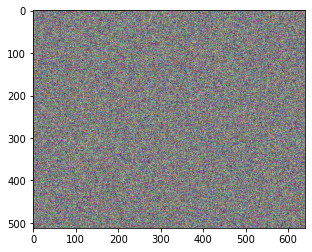

In [ ]:
content_img = image_loader('./code_practices/images/content_img_1.jpg', (512, 640))
style_img = image_loader('./code_practices/images/style_img_1.jpg', (512, 640))

print("[ Content Image ]")
imshow(content_img)
print("[ Style Image ]")
imshow(style_img)

input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
print('[ Input Image ]')
imshow(input_img)

In [ ]:
output = style_transfer(cnn, content_img, style_img, input_img, iters = 900)

Output hidden; open in https://colab.research.google.com to view.

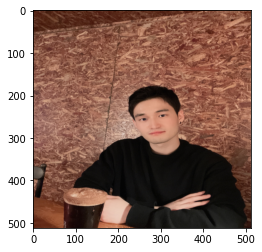

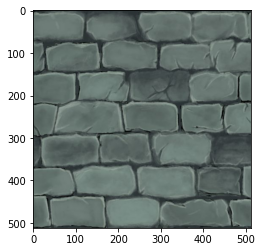

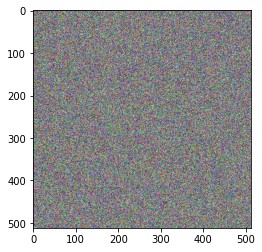

In [ ]:
content_img = image_loader('/content/drive/MyDrive/my_img.jpg', (512, 512))
style_img = image_loader('./code_practices/images/style_img_2.jpg', (512, 512))
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)

imshow(content_img)
imshow(style_img)
imshow(input_img)

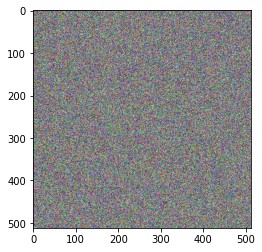

Step : 100, Content Loss : 20.125715255737305, Style Loss : 17.456073760986328


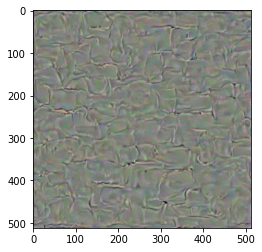

Step : 200, Content Loss : 15.637679100036621, Style Loss : 6.845345973968506


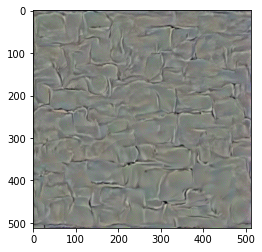

Step : 300, Content Loss : 12.966601371765137, Style Loss : 4.3853936195373535


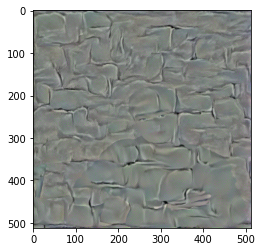

Step : 400, Content Loss : 11.283708572387695, Style Loss : 3.1859476566314697


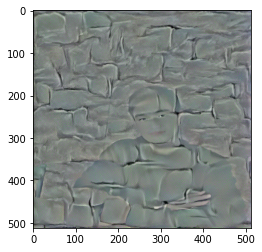

Step : 500, Content Loss : 10.130642890930176, Style Loss : 2.545672655105591


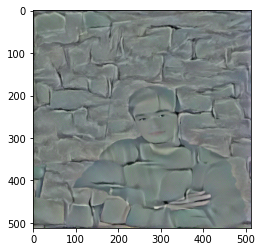

Step : 600, Content Loss : 9.368265151977539, Style Loss : 2.1858737468719482


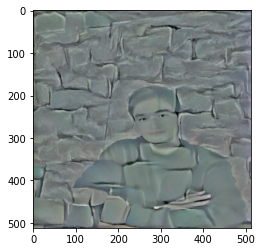

Step : 700, Content Loss : 8.77409839630127, Style Loss : 1.9214838743209839


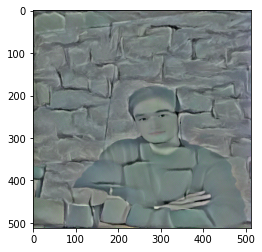

Step : 800, Content Loss : 8.352483749389648, Style Loss : 1.731353759765625


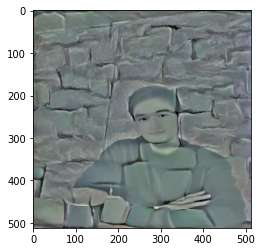

In [ ]:
output = style_transfer(cnn, content_img=content_img, style_img=style_img, input_img=input_img, iters=800)